# Библиотека Vowpal Wabbit

Vowpal Wabbit (VW) является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение  – самая сильная сторона библиотеки. 
Также реализовано хэширование признаков, и Vowpal Wabbit отлично подходит для работы с текстовыми данными.

Основным интерфейсом для работы с VW является shell.

In [22]:
!vw --help

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all 

Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [23]:
! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

For more information use: vw --help
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 1.000000
average loss = 1.000000
best constant = 1.000000
best constant's loss = 0.000000
total feature number = 10


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей письма из 20 различных тематических рассылок.


## Новости. Бинарная классификация

In [24]:
newsgroups = fetch_20newsgroups('../../data/news_data')

In [25]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Рассмотрим первый текстовый документ этой коллекции:

In [26]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов. Здесь мы не выполняем многие важные в анализе текстов процедуры (стемминг и лемматизацию), но, как увидим, задача и так будет решаться хорошо.

In [27]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили **rec.autos**. Так мы построим модель, отличающую письма про автомобили от остальных: 

In [28]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [29]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open('../../data/news_data/20news_train.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('../../data/news_data/20news_test.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge (линейный SVM). Построенную модель мы сохраним в соответствующий файл `20news_model.vw`:

In [30]:
!vw -d ../../data/news_data/20news_train.vw \
  --loss_function hinge -f ../../data/news_data/20news_model.vw

final_regressor = ../../data/news_data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000  -0.

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения (тем не менее, ее можно погасить, если задать параметр --quiet). Подробно вывод диагностическйой информации разобран в документации VW на GitHub – [тут](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому, как правило, эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [31]:
!vw -i ../../data/news_data/20news_model.vw -t -d ../../data/news_data/20news_test.vw \
-p ../../data/news_data/20news_test_predictions.txt

only testing
predictions = ../../data/news_data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   1.0000      349
0.000000 0.000000            2            2.0  unknown  -1.0000       50
0.000000 0.000000            4            4.0  unknown  -1.0000      251
0.000000 0.000000            8            8.0  unknown  -1.0000      237
0.000000 0.000000           16           16.0  unknown  -0.8978      106
0.000000 0.000000           32           32.0  unknown  -1.0000      964
0.000000 0.000000           64           64.0  unknown  -1.0000      261
0.000000 0.000000          128          128.0  unknown   0.4621       82
0.000000 0.000000          256         

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

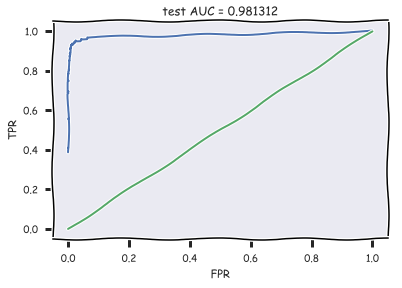

In [32]:
with open('../../data/news_data/20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

# Новости. Многоклассовая классификация

Используем ту же выборку, что в прошлой части, но решаем задачу многоклассовой классификации. Тут `Vowpal Wabbit` слегка капризничает – он любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 20). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (`LabelEncoder` переводит метки в диапозон от 0 до K-1).

In [33]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Выборки будут те же, а метки поменяются, train_labels_mult и test_labels_mult – векторы меток от 1 до 20.**

In [34]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)

In [35]:
with open('../../data/news_data/20news_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open('../../data/news_data/20news_test_mult.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Обучим Vowpal Wabbit в режиме многоклассовой классификации, передав параметр `oaa` (от "one against all"), равный числу классов. Также перечислим параметры, которые можно понастраивать, и от которых качество модели может довольно значительно зависеть (более полно – в официальном [тьюториале](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):
 - темп обучения (-l, по умолчанию 0.5) – коэффициент перед изменением весов модели при каждом изменении
 - степень убывания темпа обучения (--power_t, по умолчанию 0.5) – на практике проверено, что если темп обучения уменьшается при увеличении числа итераций стохастического градиентного спуска, то минимум функции находится лучше 
 - функция потерь (--loss_function) – от нее, по сути, зависит обучаемый алгоритм. Про функции потерь в [документации](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)
 - регуляризация (-l1) – тут надо обратить внимание на то, что в VW регуляризация считается для каждого объекта, поэтому коэффициенты регуляризации обычно берутся малыми, около $10^{-20}.$
 
 Дополнительно можно попробовать автоматическую настройку параметров Vowpal Wabbit с Hyperopt. Пока это работает только с Python 2. [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре.

In [36]:
%%time
!vw --oaa 20 ../../data/news_data/20news_train_mult.vw \
-f ../../data/news_data/20news_model_mult.vw --loss_function=hinge

final_regressor = ../../data/news_data/20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       15        1      157
1.000000 1.000000            2            2.0        2       15      159
1.000000 1.000000            4            4.0       15       10       92
1.000000 1.000000            8            8.0       16       15      129
1.000000 1.000000           16           16.0       13       12      108
0.937500 0.875000           32           32.0        2        9      115
0.906250 0.875000           64           64.0       16       16      114
0.867188 0.828125          128          128.0        8        4      110
0.816406 0.765625          256          256.0    

In [37]:
%%time
!vw -i ../../data/news_data/20news_model_mult.vw -t \
-d ../../data/news_data/20news_test_mult.vw \
-p ../../data/news_data/20news_test_predictions_mult.txt

only testing
predictions = ../../data/news_data/20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../../data/news_data/20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown        8      349
1.000000 1.000000            2            2.0  unknown        6       50
1.000000 1.000000            4            4.0  unknown       18      251
1.000000 1.000000            8            8.0  unknown       18      237
1.000000 1.000000           16           16.0  unknown        4      106
1.000000 1.000000           32           32.0  unknown       15      964
1.000000 1.000000           64           64.0  unknown        4      261
1.000000 1.000000          128          128.0  unknown        8       82
1.000000 1.000000          25

In [38]:
with open('../../data/news_data/20news_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [39]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

В качестве примера анализа резльтатов, посмотрим, с какими темами классификатор путает атеизм.

In [40]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0,i], )

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


# Рецензии к фильмам IMDB

В этой части мы будем заниматься бинарной классификацией отзывов к фильмам, публикованным на сайте IMDB. Обратите внимание, насколько быстро будет работать Vowpal Wabbit.

Используем функцию `load_files` из `sklearn.datasets` для загрузки отзывов по фильмам [отсюда](https://drive.google.com/file/d/1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l/view?usp=sharing). Скачайте данные и укажите свой путь к каталогу `imdb_reviews` (в нем должны быть каталоги *train* и *test*). Разархивирование может занять несколько минут – там 100 тыс. файлов. В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделим данные (собственно, тексты) от меток.

In [41]:
# поменяйте на свой путь
path_to_movies = '/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews/'
reviews_train = load_files(os.path.join(path_to_movies, 'train'))
text_train, y_train = reviews_train.data, reviews_train.target

In [42]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


То же самое с тестовой выборкой.

In [43]:
reviews_test = load_files(os.path.join(path_to_movies, 'test'))
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


Примеры отзывов и соответствующих меток

In [44]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [45]:
y_train[0] # хороший отзыв

1

In [46]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [47]:
y_train[1] # плохой отзыв

0

Будем использовать ранее написанную функцию `to_vw_format`.

In [48]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

Подготовим обучающую (`movie_reviews_train.vw`), отложенную (`movie_reviews_valid.vw`) и тестовую (`movie_reviews_test.vw`) выборки для Vowpal Wabbit. 70% исходной обучаюшей выборки оставим под обучение, 30% – под отложенную выборку.

In [49]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [50]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [51]:
with open('../../data/movie_reviews_train.vw', 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('../../data/movie_reviews_valid.vw', 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open('../../data/movie_reviews_test.vw', 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [52]:
!head -2 ../../data/movie_reviews_train.vw

1 |text zero day leads you think even think why two boys young men would what they did commit mutual suicide via slaughtering their classmates captures what must beyond bizarre mode being for two humans who have decided withdraw from common civility order define their own mutual world via coupled destruction not perfect movie but given what money time the filmmaker and actors had remarkable product terms explaining the motives and actions the two young suicide murderers better than elephant terms being film that gets under our rationalistic skin far far better film than almost anything you are likely see flawed but honest with terrible honesty
-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regardi

In [53]:
!head -2 ../../data/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [54]:
!head -2 ../../data/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Обучим модель Vowpal Wabbit со следующими агрументами:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [55]:
!vw -d ../../data/movie_reviews_train.vw \
--loss_function hinge -f movie_reviews_model.vw --quiet

Сделаем прогноз для отложенной выборки с помощью обученной модели Vowpal Wabbit, передав следующие аргументы:
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к отложенной выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [56]:
!vw -i movie_reviews_model.vw -t -d ../../data/movie_reviews_valid.vw \
-p movie_valid_pred.txt --quiet

Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной.

In [57]:
with open('movie_valid_pred.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


Сделаем то же самое для тестовой выборки.

In [58]:
!vw -i movie_reviews_model.vw -t -d ../../data/movie_reviews_test.vw \
-p movie_test_pred.txt --quiet

In [59]:
with open('movie_test_pred.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


Попробуем улучшить прогноз за счет задействования биграмм

In [60]:
!vw -d ../../data/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f movie_reviews_model2.vw --quiet

In [61]:
!vw -i movie_reviews_model2.vw -t -d ../../data/movie_reviews_valid.vw \
-p movie_valid_pred2.txt --quiet

In [62]:
with open('movie_valid_pred2.txt') as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [63]:
!vw -i movie_reviews_model2.vw -t -d ../../data/movie_reviews_test.vw \
-p movie_test_pred2.txt --quiet

In [64]:
with open('movie_test_pred2.txt') as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Видим, что биграммы помогли повысить качество классификации.

## Классификация вопросов на StackOverflow 

Теперь посмотрим, как в действительности Vowpal Wabbit справляется с большими выборками. Имеются 10 Гб вопросов со StackOverflow – [ссылка](https://cloud.mail.ru/public/3bwi/bFYHDN5S5) на данные, там аккурат 10 миллионов вопросов, и у каждого вопроса может быть несколько тегов. Данные довольно чистые, и не называйте это бигдатой даже в пабе :)

<img src='../../img/say_big_data.jpg' width=50%>

Из всех тегов выделены 10, и решается задача классификации на 10 классов: по тексту вопроса надо поставить один из 10 тегов, соответствующих 10 популярным языкам программирования. Предобработанные данные не даются, поскольку их надо получить в домашней работе.

In [65]:
# поменяйте путь к данным
PATH_TO_DATA = '/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw/'

In [66]:
!du -hs $PATH_TO_DATA/stackoverflow_10mln_*.vw

1,4G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_test.vw
3,3G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_train.vw
1,9G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_train_part.vw
1,4G	/Users/y.kashnitsky/Documents/Machine_learning/org_mlcourse_open/private/stackoverflow_hw//stackoverflow_10mln_valid.vw


Вот как выглядят строки, на которых будет обучаться Vowpal Wabbit. 10 означает 10 класс, далее вертикальная черта и просто текст вопроса. 

In [67]:
!head -1 $PATH_TO_DATA/stackoverflow_10mln_train.vw

10 | i ve got some code in window scroll that checks if an element is visible then triggers another function however only the first section of code is firing both bits of code work in and of themselves if i swap their order whichever is on top fires correctly my code is as follows fn isonscreen function use strict var win window viewport top win scrolltop left win scrollleft bounds this offset viewport right viewport left + win width viewport bottom viewport top + win height bounds right bounds left + this outerwidth bounds bottom bounds top + this outerheight return viewport right lt bounds left viewport left gt bounds right viewport bottom lt bounds top viewport top gt bounds bottom window scroll function use strict var load_more_results ajax load_more_results isonscreen if load_more_results true loadmoreresults var load_more_staff ajax load_more_staff isonscreen if load_more_staff true loadmorestaff what am i doing wrong can you only fire one event from window scroll i assume not


Обучим на обучающей части выборки (3.3 Гб) модель Vowpal Wabbit со следующими аргументами: 
- -oaa 10 – указываем, что классификация на 10 классов 
- -d – путь к данным 
- -f – путь к модели, которая будет построена 
- -b 28 – используем 28 бит для хэширования, то есть признаковое пространство ограничено $2^{28}$ признаками, что в данном случае больше, чем число уникальных слов в выборке (но потом появятся би- и триграммы, и ограничение размерности признакового пространства начнет работать)
- также указываем random seed

In [68]:
%%time
!vw --oaa 10 -d $PATH_TO_DATA/stackoverflow_10mln_train.vw \
-f vw_model1_10mln.vw -b 28 --random_seed 17 --quiet

CPU times: user 706 ms, sys: 256 ms, total: 962 ms
Wall time: 43 s


Заметим, что модель обучилась всего за 43 секунды, для тестовой выборки прогнозы сделала еще за 15 секунд, доля правильных ответов – почти 92%. Далее качество модели можно повышать за счет нескольких проходов по выборке, задействования биграмм и настройке параметров. Это вместе с предобработкой данных и будет второй частью домашнего задания.

In [69]:
%%time
!vw -t -i vw_model1_10mln.vw \
-d $PATH_TO_DATA/stackoverflow_10mln_test.vw \
-p vw_valid_10mln_pred1.csv --random_seed 17 --quiet

CPU times: user 231 ms, sys: 90.5 ms, total: 322 ms
Wall time: 14.8 s


In [70]:
import os
import numpy as np
from sklearn.metrics import accuracy_score

vw_pred = np.loadtxt('vw_valid_10mln_pred1.csv')
test_labels = np.loadtxt(os.path.join(PATH_TO_DATA, 
                                      'stackoverflow_10mln_test_labels.txt'))
accuracy_score(test_labels, vw_pred)

0.91868709729356979